# Laplace equation - matrix methods

Physics 481 Fall 2021 Week 09a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction
 
Numerical solutions of Laplace's equation can be expressed as a set of linear equations.  This allows the use of matrix methods and depends on an understanding of issues such as inversion stability and sparse matrices.

 
 
### Theory

The electrostatic potential $V$ due to some charge $\rho$ must satisfy Poisson's equation 

  $$ \nabla^2 V = \rho $$

For a charge-free region ($\rho=0$) this reduces to Laplace's equation

  $$ \nabla^2 V = 0 $$
  
which can be written in Cartesian coordinates

  $$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2} = 0 $$

## 1D rectangular

If $V$ depends on only one variable, $x$, then Laplace's equation in Cartesian coordinates becomes

  $$ \frac{\partial^2 V}{\partial x^2} = 0 $$

The general solution is obtained by integrating twice 

  $$ V(x) = m x + b $$

If we only consider discrete locations

  $$ x_i = i \Delta x $$

then the centered second difference  is

$$ \frac{\partial^2 V}{\partial x^2}  
\approx  \left . \frac{\partial V}{\partial x} \right |_{x_{i+1}} -  \left . \frac{\partial V}{\partial x} \right |_{x_i}
\approx
\frac{V_{i+1}-V_{i}}{x_{i+1}-x_{i}} - \frac{V_{i}-V_{i-1}}{x_{i}-x_{i-1}}
\approx 
\frac{V_{i+1} - 2V_i + V_{i-1}}{\Delta x^2} = 0
$$
  
From this the potential at any location

 $$  V_i = \frac{V_{i-1} + V_{i+1}}{2} $$
 
can be determined by calculating the average of the two nearest neighbors.  This suggests that an iterative approach (relaxation methods) might be used to solve for the potential profile.

## Laplace 2D

In two dimensions, Laplace's equation in Cartesian coordinates reduces to

  $$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0 $$

We can replace the continous spatial dimensions by a lattice with finite spacing

  $$ x_i = i \Delta x $$
  $$ y_j = j \Delta y $$

to see that the potential at each point is given by the average at the four closest adjoining sites *if* $\Delta x = \Delta y$

 $$ V(x_i, y_j) = V_{i,j} = \frac{V_{i-1,j} + V_{i+1,j} + V_{i,j-1} + V_{i,j+1}}{4} $$
 
For unequally spaced grids things are slightly more complicated

 $$ V_{i,j} = \frac{ \left ( V_{i-1,j} + V_{i+1,j} \right ) \Delta y^2 + \left ( V_{i,j+1} + V_{i,j-1} \right ) \Delta x^2 }{2(\Delta x^2 + \Delta y^2 )} $$
 
It is tempting to try and avoid dealing with the details of grid spacing by making a choice of grid dimensions that conveniently aligns with the physical boundaries.  

However, it is arguably preferrable to write code that can deal with arbitrary grid sizes and spacings.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

## Matrix methods

Relationships between the grid points can be written in a very compact way with matrix algebra

$$
 \mathbf{A} \mathbf{x} = \mathbf{y}
$$

For example, a 1-dimensional system with 5 grid points at locations

  $$ x_0, \; x_1, \; \ldots \; x_4 $$

with arbitrary voltages

  $$V(x_0)=V_0, \; V(x_1)=V_1, \; \ldots \; V(x_4)=V_4 $$
  
and boundary conditions at $x_0$ and $x_4$ gives a coupled set of 5 linear equations

 $$ V_0 = V_a $$
 $$ V_0 -2 V_1 + V_2 = 0 $$
 $$ V_1 -2 V_2 + V_3 = 0 $$ 
 $$ V_2 -2 V_3 + V_4 = 0 $$ 
 $$ V_4 = V_b $$

which can be expressed as a square matrix that contains the physics of Laplace's equation
and a column matrix containing the two boundary conditions
 $$  
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & -2 & 1 & 0 & 0 \\
0 & 1 & -2 & 1 & 0  \\
0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
 \begin{pmatrix}
 V_0 \\ V_1 \\ V_2 \\ V_3 \\ V_4
 \end{pmatrix}
=
 \begin{pmatrix}
 V_a \\ 0 \\ 0 \\ 0 \\ V_b
 \end{pmatrix}  
 $$


In general, this means that the voltages can be solved for using the matrix inverse

$$
  \mathbf{x} = \mathbf{A}^{-1} \mathbf{y}
$$
 

 
 $$  
 \begin{pmatrix}
 V_0 \\ V_1 \\ V_2 \\ V_3 \\ V_4
 \end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & -2 & 1 & 0 & 0 \\
0 & 1 & -2 & 1 & 0  \\
0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}^{-1}
 \begin{pmatrix}
 V_a \\ 0 \\ 0 \\ 0 \\ V_b
 \end{pmatrix}
 $$

In [42]:
A = np.zeros( (5,5), dtype=np.double)
A[0,0] = 1.0
A[1,:] = [1, -2, 1, 0, 0]
A[2,:] = [0, 1, -2, 1, 0]
A[3,:] = [0, 0, 1, -2, 1]
A[4,4] = 1.0

y = np.array([0,0,0,0,1])  # column matrix of boundary conditions V(x=0)=0, V(x=1)=1

print( 'Inverse: \n', np.linalg.inv(A) )

print( '\nSolution: ', np.matmul( np.linalg.inv(A), y) )

Inverse: 
 [[ 1.    0.    0.    0.    0.  ]
 [ 0.75 -0.75 -0.5  -0.25  0.25]
 [ 0.5  -0.5  -1.   -0.5   0.5 ]
 [ 0.25 -0.25 -0.5  -0.75  0.75]
 [ 0.    0.    0.    0.    1.  ]]

Solution:  [0.   0.25 0.5  0.75 1.  ]


This can be applied at any grid resolution to produce a `tridiagonal` matrix

$$ \begin{bmatrix}
   a_{1} & c_1 &  & & \\ 
   b_1 & a_{2} & c_2 & & & \\ 
   & b_2 & a_{3} & c_3 & \\   
   &  & \ddots & \ddots & \ddots &\\ 
   & & &  \ddots  & a_{n-1} & c_{n-1} \\
   & & & & b_{n-1} & a_n 
 \end{bmatrix}
$$

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]]


Text(0.5, 1.0, 'Tridiagonal matrix')

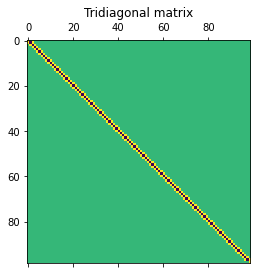

In [39]:
ngrid=99
A = np.zeros( (ngrid,ngrid), dtype=np.double)
A[0,0] = 1.0
A[-1,-1] = 1.0
for indx in range(1,ngrid-1):
    A[indx, indx-1:indx+2] = np.array( [1, -2, 1] )

print( A )
    
plt.matshow( A )
plt.title('Tridiagonal matrix')

https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm

In [40]:
def laplace1d_matrix(ngrid=99, Va=0, Vb=1.0, invert=False):
    """ Solve 1-dimensional Laplace equation using matrix methods.
    """
    A = np.zeros( (ngrid,ngrid), dtype=np.double)
    A[0,0] = 1.0
    A[-1,-1] = 1.0
    for indx in range(1,ngrid-1):
        A[indx, indx-1:indx+2] = np.array( [1, -2, 1] )
        
    y= np.zeros( ngrid, dtype=np.double ) 
    y[0] = Va
    y[-1] = Vb

    if invert:
        v = np.matmul( np.linalg.inv(A), y)        
        
    else:
        v = np.linalg.solve(A, y)      
    
    return (v, A, y)

In [46]:
v, A, y = laplace1d_matrix(ngrid=6, Va=0, Vb=1.0)
print(v, '\n\n', A, '\n\n', y)

[0.  0.2 0.4 0.6 0.8 1. ] 

 [[ 1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1.]] 

 [0. 0. 0. 0. 0. 1.]


#### Condition number

Condition number gives an indication of inversion stability.
It is essentially a factor which multiplies input numerical noise
to produce (usually much) more noise in the output.

In [14]:
#
# 1 is great, 10-1000 is fine, 1e9 is trouble
#
np.linalg.cond(A)

10.994600319765407

In [16]:
# Equivalently, take a look at matrix inverse.  
# If there are a mixture of very small (1e-9) and very large (1e-9) values then 
# we should expect numerical problems.
#
np.linalg.inv(A)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.8, -0.8, -0.6, -0.4, -0.2,  0.2],
       [ 0.6, -0.6, -1.2, -0.8, -0.4,  0.4],
       [ 0.4, -0.4, -0.8, -1.2, -0.6,  0.6],
       [ 0.2, -0.2, -0.4, -0.6, -0.8,  0.8],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])

#### Solve, don't invert

For a set of linear equations $A x = b$ we may write the solution in terms of a matrix inverse $x = A^{-1} b$. However, this is not always the best way to proceed numerically if we are just interested in the solution and don't actually require the inverse.  

Instead, call a `solve` function which will usually give a result for $x$ that is more computationally efficient and numerically stable.

In [19]:
%timeit np.matmul( np.linalg.inv(A), v)
%timeit np.linalg.solve( A, v)

7.18 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.6 µs ± 69.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Theory vs. numerics : speed

Computing time scales as $O(N^2)$, with matrix inversion taking roughly 50% to 100% longer than solving.

In [20]:
print('\n numpy.linalg.solve ()')
%timeit laplace1d_matrix(9)   
%timeit laplace1d_matrix(99)
%timeit laplace1d_matrix(199)
%timeit laplace1d_matrix(399)

print('\n Inversion is 1.5x to 2.0x times slower:')
%timeit laplace1d_matrix(9, invert=True)   
%timeit laplace1d_matrix(99, invert=True)
%timeit laplace1d_matrix(199, invert=True)
%timeit laplace1d_matrix(399, invert=True)


 numpy.linalg.solve ()
20.1 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
189 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
461 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

 Inversion is 1.5x to 2.0x times slower:
23.3 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
249 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
608 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.4 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Theory vs. numerics : accuracy

There is a systematic discrepancy between theory and numerical results.  For a $99 \times 99$ grid the error is comparable to floating point truncation error (approx 1e-15).  For a $999 \times 999$ grid the discrepancy is larger (1e-13) and has a different profile.

This shows that using bigger grids can actually be worse, with small errors accumulating up over a larger number of calculations.

Text(0.5, 1.0, 'n=1999')

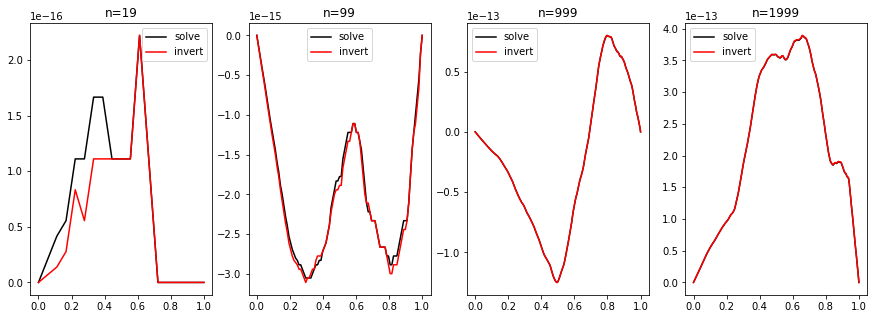

In [24]:
fig, axes = plt.subplots( 1, 4, figsize=(15,5) )

plt.sca( axes[0] )
Vtheory = np.linspace(0, 1.0, 19)
Vsolve, *_ = laplace1d_matrix(19) 
Vinvert, *_ = laplace1d_matrix(19, invert=True)  
plt.plot(Vtheory, Vsolve - Vtheory, 'k-', label='solve')
plt.plot(Vtheory, Vinvert - Vtheory, 'r-', label='invert')
plt.legend( loc=0 )
plt.title('n=19')

plt.sca( axes[1] )
Vtheory = np.linspace(0, 1.0, 99)
Vsolve, *_ = laplace1d_matrix(99) 
Vinvert, *_ = laplace1d_matrix(99, invert=True)  
plt.plot(Vtheory, Vsolve - Vtheory, 'k-', label='solve')
plt.plot(Vtheory, Vinvert - Vtheory, 'r-', label='invert')
plt.legend( loc=0 )
plt.title('n=99')

plt.sca( axes[2] )
Vtheory = np.linspace(0, 1.0, 999)
Vsolve, *_ = laplace1d_matrix(999) 
Vinvert, *_= laplace1d_matrix(999, invert=True)  
plt.plot(Vtheory, Vsolve - Vtheory, 'k-' , label='solve')
plt.plot(Vtheory, Vinvert - Vtheory, 'r-' , label='invert')
plt.legend( loc=0 )
plt.title('n=999')

plt.sca( axes[3] )
Vtheory = np.linspace(0, 1.0, 1999)
Vsolve, *_ = laplace1d_matrix(1999) 
Vinvert, *_ = laplace1d_matrix(1999, invert=True)  
plt.plot(Vtheory, Vsolve - Vtheory, 'k-' , label='solve')
plt.plot(Vtheory, Vinvert - Vtheory, 'r-' , label='invert')
plt.legend( loc=0 )
plt.title('n=1999')

## Special cases

Solving a general matrix equation requires $O(N^3)$ operations and may involve numerical problems.

If the matrix has some special property then it may be possible to take advantage of this to obtain more accurate results more quickly.

In [54]:
[name for name in dir(scipy.linalg) if 'solve' in name]

['_solve_toeplitz',
 '_solvers',
 'cho_solve',
 'cho_solve_banded',
 'lu_solve',
 'solve',
 'solve_banded',
 'solve_circulant',
 'solve_continuous_are',
 'solve_continuous_lyapunov',
 'solve_discrete_are',
 'solve_discrete_lyapunov',
 'solve_lyapunov',
 'solve_sylvester',
 'solve_toeplitz',
 'solve_triangular',
 'solveh_banded']

In [74]:
# A tri-diagonal matrix has a simple banded structure.

banded = np.zeros( (A.shape[0], 3) )

banded[0,0] = 0
banded[1:,0] = -1

banded[0:,1] = 2

banded[0:-1,2] = -1
banded[-1,2] = 0

scipy.linalg.solve_banded((1,1), banded.T, y ) [::9]

(100, 3) (100,)


array([0.00990099, 0.0990099 , 0.18811881, 0.27722772, 0.36633663,
       0.45544554, 0.54455446, 0.63366337, 0.72277228, 0.81188119,
       0.9009901 , 0.99009901])

In [75]:
# Using the special "banded" algorithm is 6x faster than the general case.
#

%timeit scipy.linalg.solve(A, y);
%timeit scipy.linalg.solve_banded((1,1), banded.T, y );

#7.4 µs ± 98.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
#110 µs ± 870 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

17.4 µs ± 98.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
110 µs ± 870 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Sparse Linear Systems
Numerical Recipes p72 http://www.aip.de/groups/soe/local/numres/bookcpdf/c2-7.pdf

A system of linear equations is called *sparse* if only a relatively small number of its matrix elements $a_{ij}$ are nonzero.  It is wasteful to use general methods of linear algebra on such problems, because most of the $O(N^3)$ arithmetic operations devoted to solving the set of equations or inverting the matrix involve adding or multiplying by zeros.  Furthermore, you might wish to work problems so large as to tax your available memory space, and it is wasteful to reserve storage for large numbers of zeros.  Note that there are two distinct (and not always compatible) goals for any sparse matrix method: saving time and/or saving space.

See also: 

https://en.wikipedia.org/wiki/Sparse_matrix

https://www.sharcnet.ca/help/index.php/Solving_Systems_of_Sparse_Linear_Equations

http://hplgit.github.io/bumpy/doc/pub/lectures-basics-1.html#___sec28


In [26]:
import scipy.sparse, scipy.sparse.linalg
N = 99
lower = np.ones(N-1)
diag = -2*np.ones(N) ; diag[0] = diag[-1] = 1 #; print(diag)
upper = np.ones(N-1)

#np.diag(lower, -1) + np.diag(diag,0) + np.diag(upper, +1)
sparseA = scipy.sparse.diags([lower,diag,upper], [-1,0,1] ) ; print( sparseA.__sizeof__() )

b = np.zeros(N) ; b[-1] = 1.0
scipy.sparse.linalg.spsolve( sparseA, b )

32


array([-0.00257732,  0.00257732,  0.00773196,  0.0128866 ,  0.01804124,
        0.02319588,  0.02835052,  0.03350515,  0.03865979,  0.04381443,
        0.04896907,  0.05412371,  0.05927835,  0.06443299,  0.06958763,
        0.07474227,  0.07989691,  0.08505155,  0.09020619,  0.09536082,
        0.10051546,  0.1056701 ,  0.11082474,  0.11597938,  0.12113402,
        0.12628866,  0.1314433 ,  0.13659794,  0.14175258,  0.14690722,
        0.15206186,  0.15721649,  0.16237113,  0.16752577,  0.17268041,
        0.17783505,  0.18298969,  0.18814433,  0.19329897,  0.19845361,
        0.20360825,  0.20876289,  0.21391753,  0.21907216,  0.2242268 ,
        0.22938144,  0.23453608,  0.23969072,  0.24484536,  0.25      ,
        0.25515464,  0.26030928,  0.26546392,  0.27061856,  0.2757732 ,
        0.28092784,  0.28608247,  0.29123711,  0.29639175,  0.30154639,
        0.30670103,  0.31185567,  0.31701031,  0.32216495,  0.32731959,
        0.33247423,  0.33762887,  0.34278351,  0.34793814,  0.35

## Scipy Sparse Matricies

https://docs.scipy.org/doc/scipy/reference/sparse.html

Sparse matrix classes:

    bsr_matrix(arg1[, shape, dtype, copy, blocksize])  Block Sparse Row matrix
    
    coo_matrix(arg1[, shape, dtype, copy])  A sparse matrix in COOrdinate format
    
    csc_matrix(arg1[, shape, dtype, copy])  Compressed Sparse Column matrix
    
    csr_matrix(arg1[, shape, dtype, copy])  Compressed Sparse Row matrix
    
    dia_matrix(arg1[, shape, dtype, copy]) Sparse matrix with DIAgonal storage
    
    dok_matrix(arg1[, shape, dtype, copy]) Dictionary Of Keys based sparse matrix
    
    lil_matrix(arg1[, shape, dtype, copy])  Row-based list of lists sparse matrix

    spmatrix([maxprint]) provides a base class for all sparse matrices.

For usage information, see

https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information



In [49]:
# demonstrate how to convert a numpy ndarray to CSR format and back again
#
v, A, y = laplace1d_matrix(4)
s = scipy.sparse.csr_matrix(A)
assert( np.all( s.toarray() == A ) )

In [50]:
# compare sparse and full matrix storage requirement
#
#
stack = []
for n in [3,5,10,20,100,200,500,1000]:
    v, A, y = laplace1d_matrix(n)
    s = scipy.sparse.csr_matrix(A)
    stack.append( (n, s.count_nonzero(), A.size, s.size ) )

print( *stack , sep='\n' )

(3, 5, 9, 5)
(5, 11, 25, 11)
(10, 26, 100, 26)
(20, 56, 400, 56)
(100, 296, 10000, 296)
(200, 596, 40000, 596)
(500, 1496, 250000, 1496)
(1000, 2996, 1000000, 2996)


Text(0.5, 0, 'array width,length')

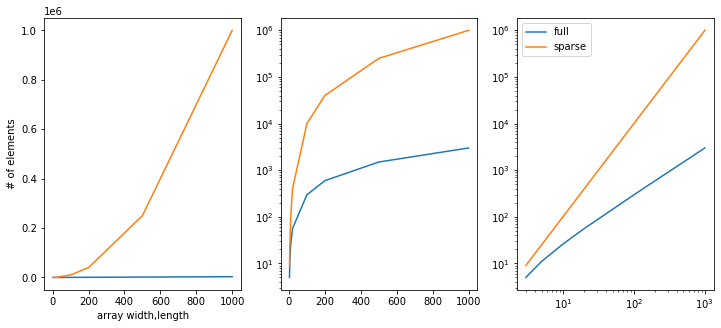

In [51]:
stack = np.array(stack)
fig, axes = plt.subplots(1,3, figsize=(12,5))
for indx,ax in enumerate(axes):
    ax.plot(stack[:,0], stack[:,1], label='full')
    ax.plot(stack[:,0], stack[:,2], label='sparse')
    if indx==2:
        ax.set_xscale('log')
    if indx >= 1:
        ax.set_yscale('log')
plt.legend( loc=0 )
axes[0].set_ylabel('# of elements')
axes[0].set_xlabel('array width,length')

In [55]:
v, A, y = laplace1d_matrix(100)
s = scipy.sparse.csr_matrix(A)
sparse.linalg.spsolve(s, y)[::9]

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        ])

Even for a not very large array ($N=100$) the sparse solver is almost twice as fast as the full matrix approach.

In [59]:
%timeit scipy.linalg.solve(A, y)
#%timeit scipy.linalg.solve(A, y, assume_a='sym')
%timeit sparse.linalg.spsolve(s, y)

112 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
148 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
69.2 µs ± 709 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [77]:
110/17.4

6.321839080459771